In [73]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import utils as ut
import LIM_class
plt.style.use("../plotting.mplstyle")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
data = xr.open_dataset("./data/ts_Amon_CESM2_piControl_r1i1p1f1.nc")["ts"]
#data = xr.open_dataset("./data/zos_Amon_CESM2_piControl_r1i1p1f1.nc")["zos"]
#data2 = xr.open_dataset("./data/ssta_1950_2021.nc")["ssta"]
mask = xr.open_dataset("./data/sftlf_fx_CESM2_historical_r1i1p1f1.nc")["sftlf"]
print()

#14400 orginial size
data = data[:, :, :]
print("Data : {} + shape : {}".format(data, data.shape))
#print("Mask : {} + shape : {}".format(mask, mask.shape))

data = ut.apply_mask(mask, data)
data = ut.calculate_monthly_anomalies(data)
data_cropped =ut.crop_xarray(data)
#print("Data cropped : {} + shape : {}".format(data_cropped, data_cropped.shape))

pca_10 = ut.SpatioTemporalPCA(data_cropped, n_components=20)
eof_10 = pca_10.eofs()
pc_10 = pca_10.principal_components()


Data : <xarray.DataArray 'ts' (time: 14400, lat: 192, lon: 288)>
[796262400 values with dtype=float32]
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 -180.0 -178.8 -177.5 -176.2 ... 176.2 177.5 178.8
  * time     (time) object 0001-01-15 12:00:00 ... 1200-12-15 12:00:00
Attributes: (12/19)
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        Surface temperature (skin for open ocean)
    description:    Surface temperature (skin for open ocean)
    frequency:      mon
    id:             ts
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Surface Temperature
    type:           real
    units:          K
    variable_id:    ts + shape : (14400, 192, 288)


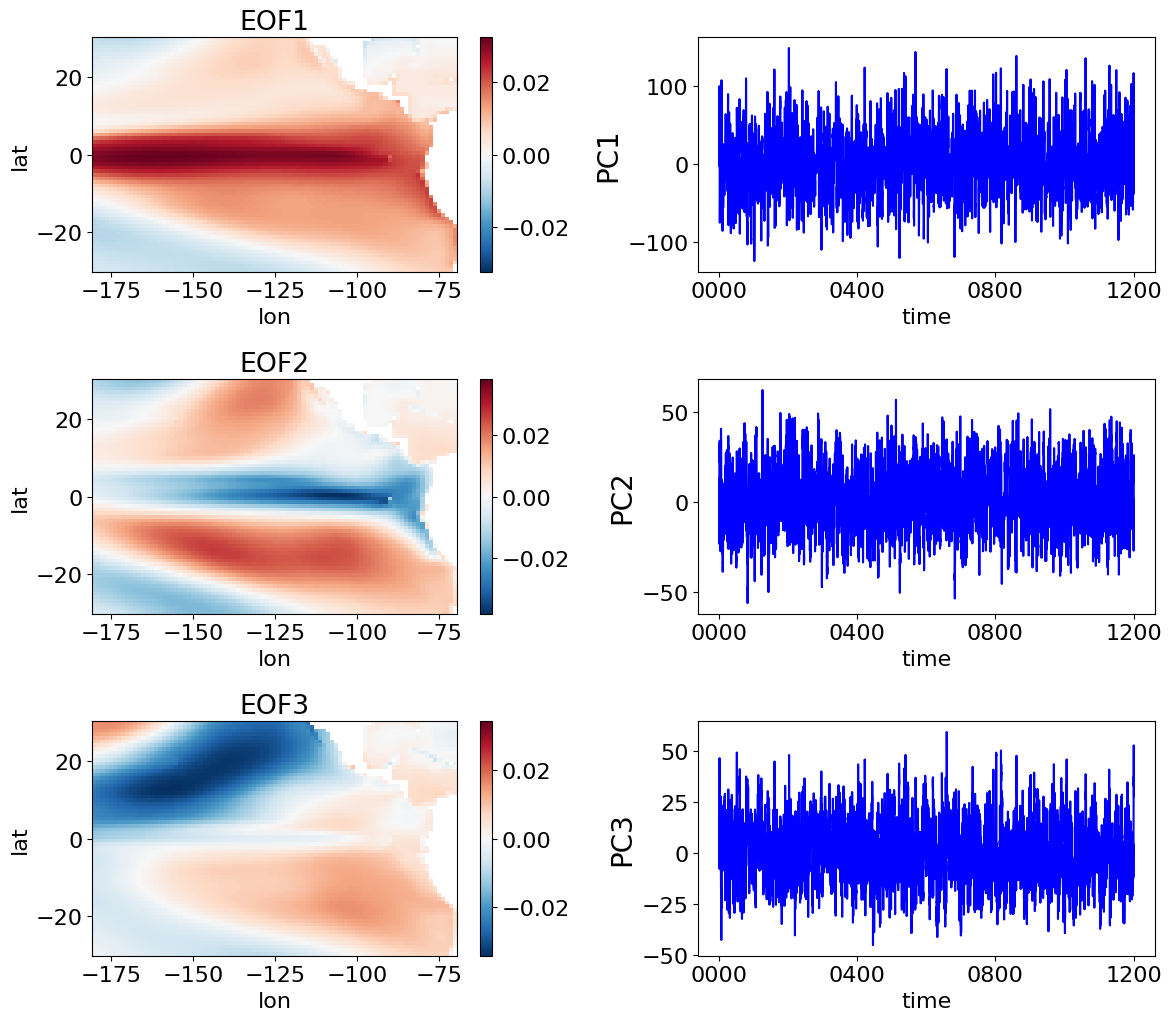

In [75]:
# Set the number of plots to 2
number_of_plots = 3

# Create the figure and axes objects
fig = plt.figure(figsize=(2 * 6, 3.5 * number_of_plots))

# Set titles and plot the contourf and plot for each EOF and PC
for i in range(number_of_plots):
    ax = fig.add_subplot(number_of_plots, 2, 2*i+1)
    eof_10[i].plot(ax=ax, cmap="RdBu_r")
    ax.set_title(f"EOF{i+1}")
    ax = fig.add_subplot(number_of_plots, 2, 2*i + 2)
    pc_10.isel(eof=i).plot(ax=ax, color="blue")
    ax.set_ylabel(f"PC{i+1}", fontsize=20)

# Add padding between subplots and adjust layout
fig.tight_layout(pad=2)
fig.savefig('./plots/svg/EOFS_timeseries_piControl.svg', format='svg')
fig.savefig('./plots/png/EOFS_timeseries_piControl.png', format='png')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


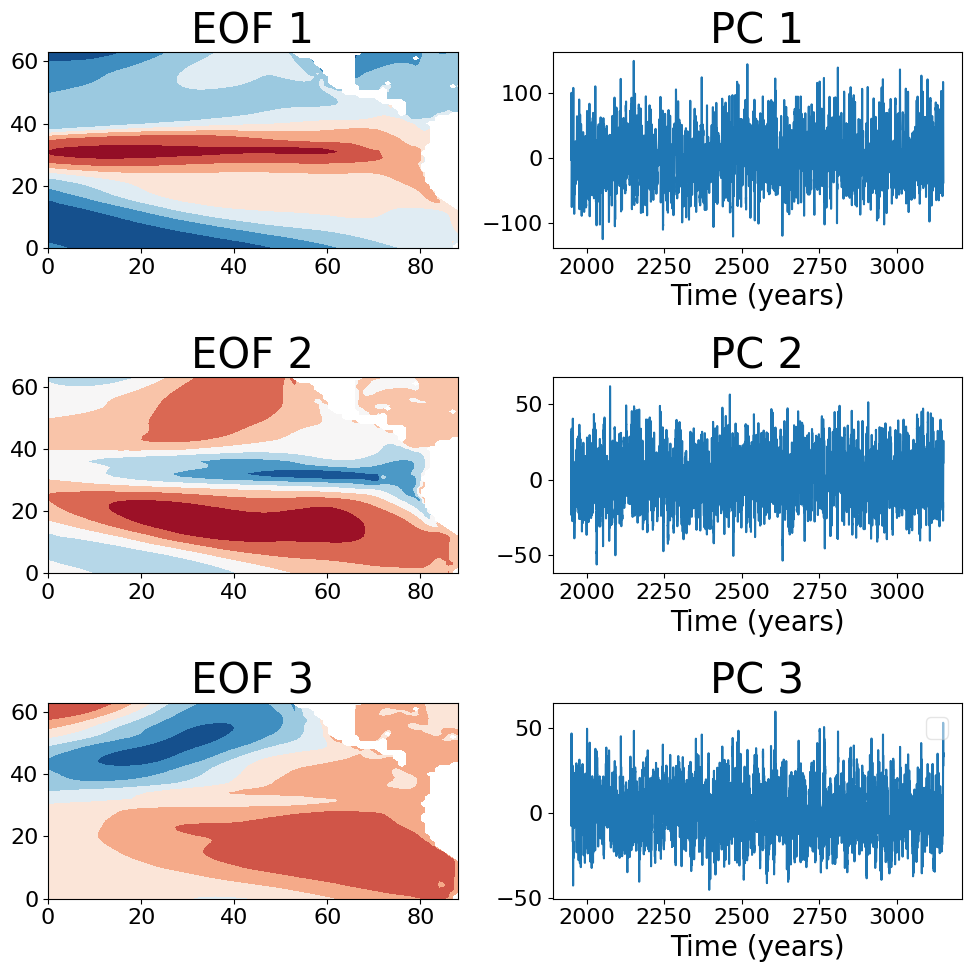

In [76]:
# Set the number of plots to 2
number_of_plots = 3

# Create the figure and axes objects
fig, axs = plt.subplots(number_of_plots, 2, figsize=(10, 10))

# Set titles and plot the contourf and plot for each EOF and PC
for i in range(number_of_plots):
    axs[i,0].set_title("EOF {}".format(i + 1), fontsize=30)
    axs[i,0].contourf(eof_10[i], cmap="RdBu_r")
    axs[i,1].set_title("PC {}".format(i + 1), fontsize=30)
    # Define time variable
    time = np.arange(len(pc_10[i]))
    # Convert time to years
    time_years = time/12 + 1950
    # Plot PC with time on x-axis in years
    axs[i,1].plot(time_years, pc_10[i])
    axs[i,1].set_xlabel("Time (years)", fontsize=20)

plt.legend(loc="upper right", fontsize=20)
# Add padding between subplots and adjust layout
fig.tight_layout(pad=2)
fig.savefig('./plots/svg/EOFS_timeseries_RdBu_r_piControl.svg', format='svg')
fig.savefig('./plots/png/EOFS_timeseries_RdBu_r_piControl.png', format='png')
plt.show()

In [77]:
# Create training and test data
data = pca_10.principal_components()
index_train = int(0.8 * len(data["time"]))
data_train = data[:, :index_train]
data_test = data[:, index_train:]

# Creating an example LIM object
tau = 1
model = LIM_class.LIM(tau)
model.fit(data_train.data)

Covariance matrix has negative values!


Performing LIM forecast for tau values: [0, 1, 2, 3, 4, 5, 6]


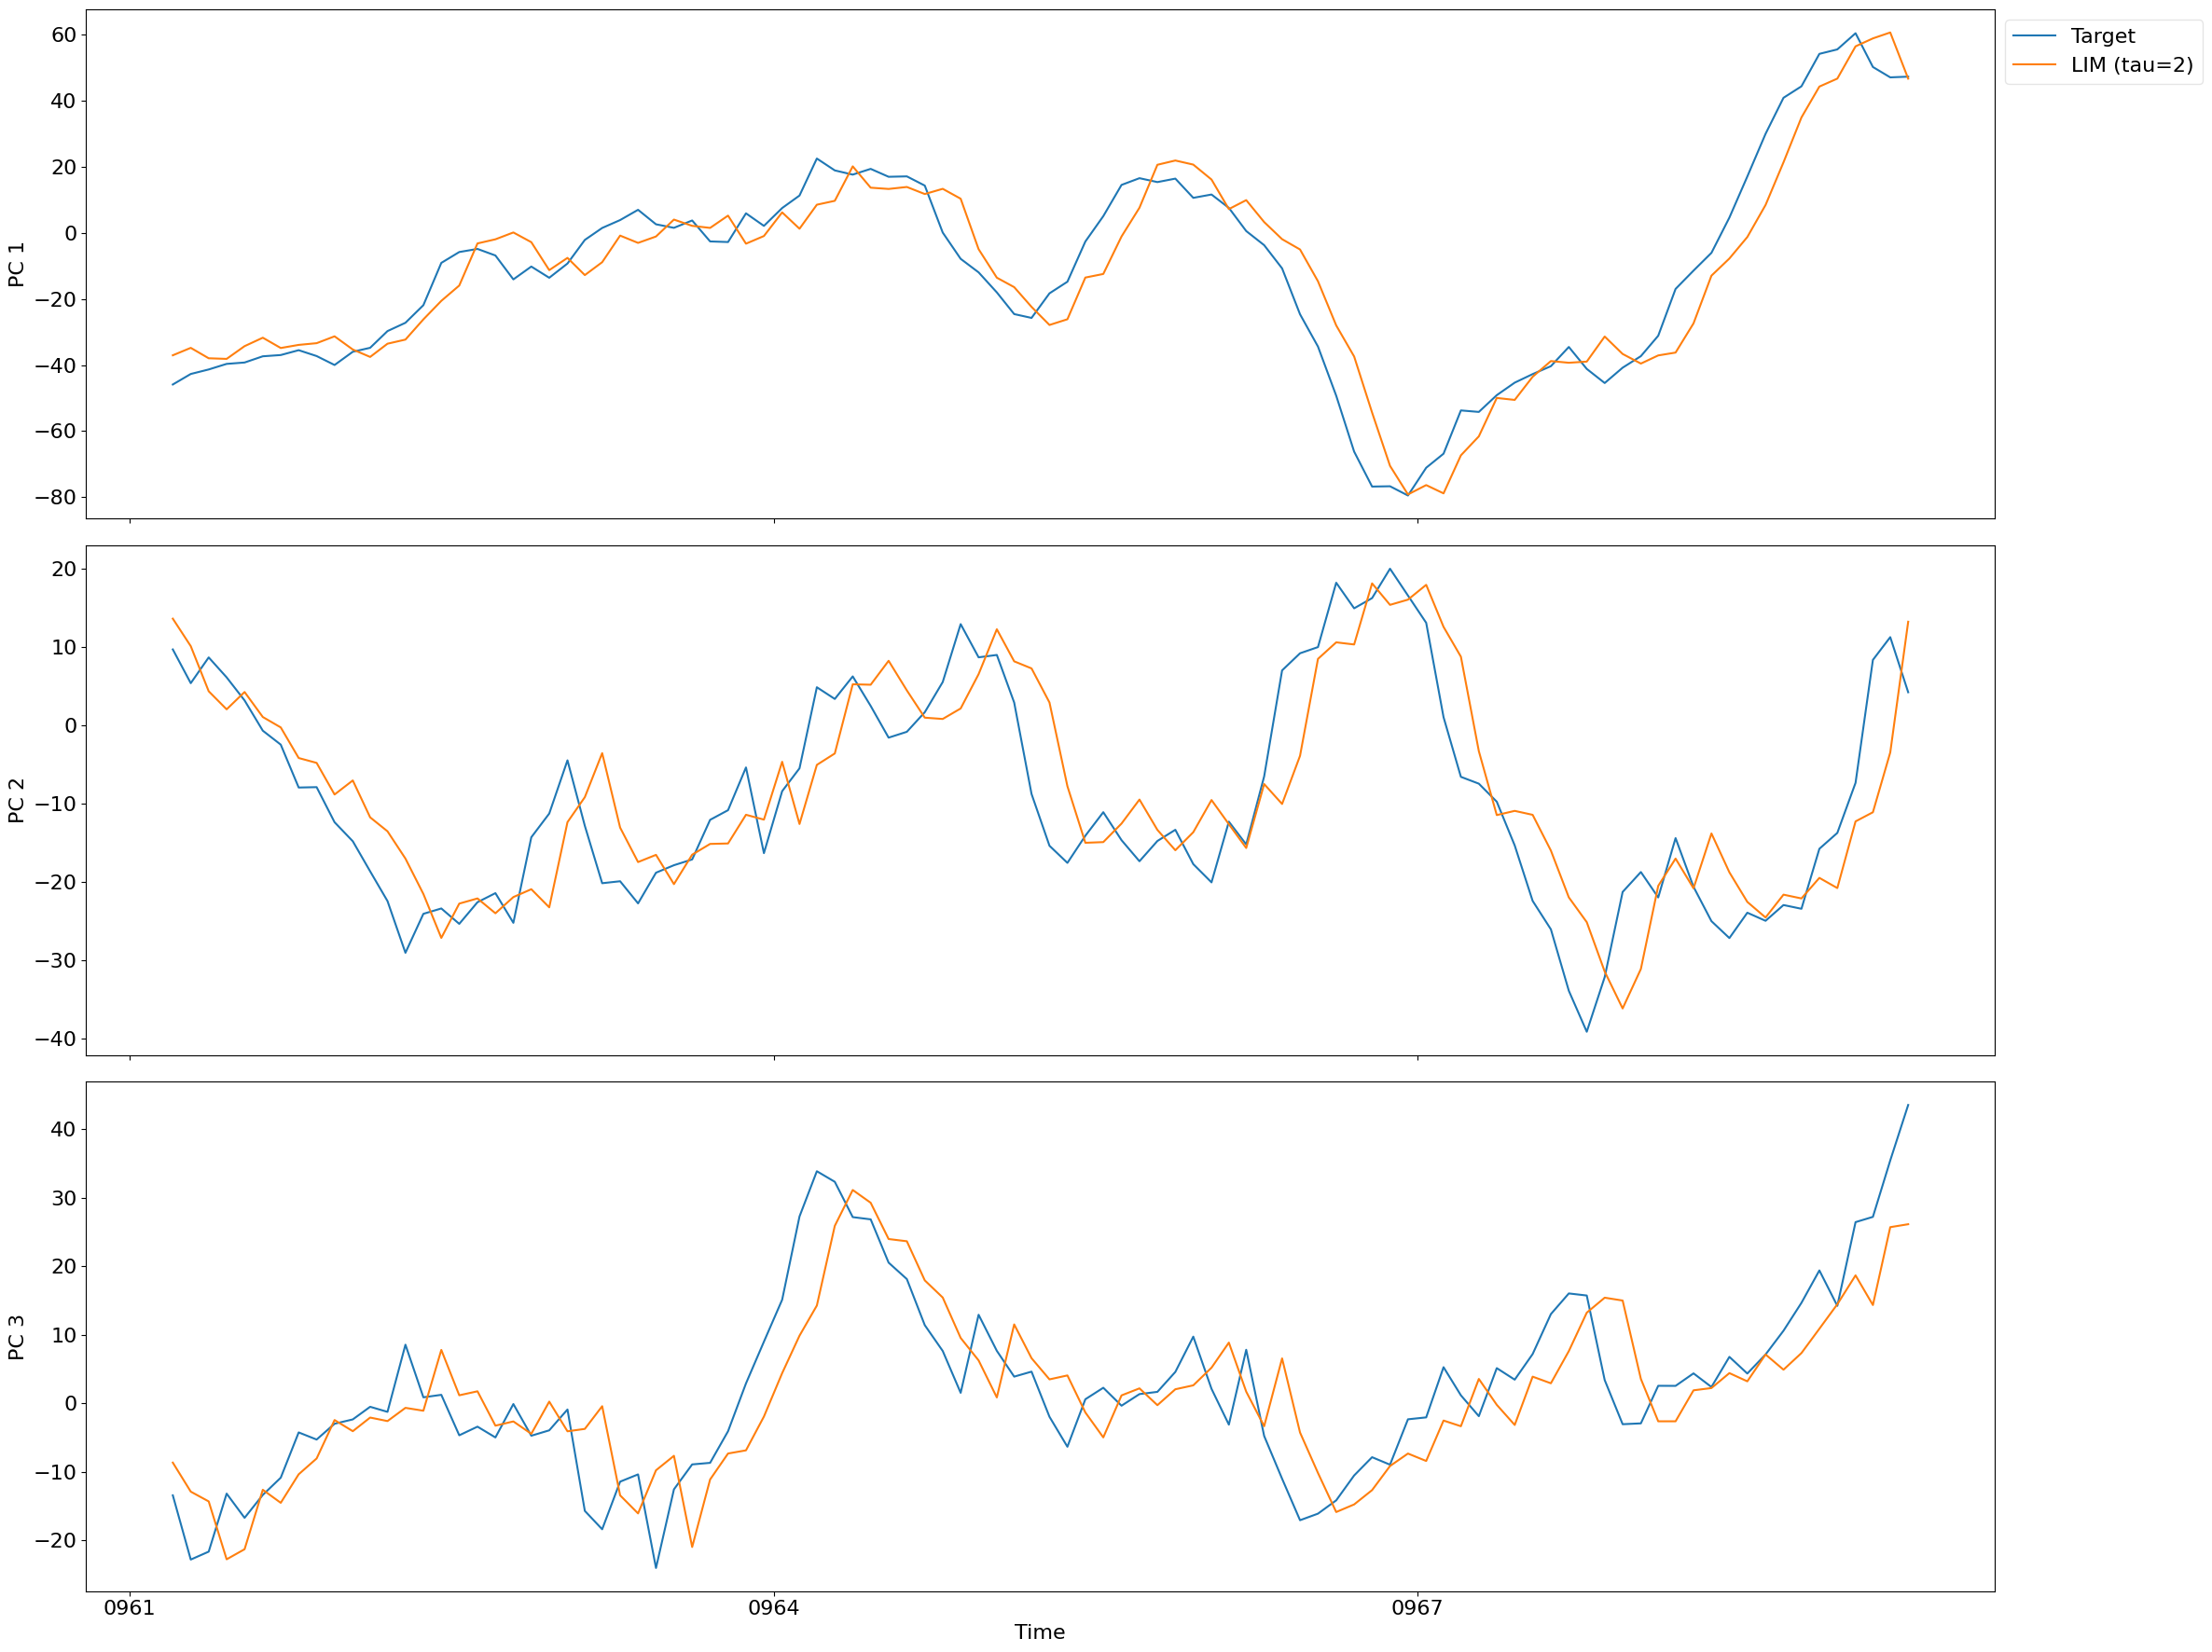

In [78]:
# Forecasting

# Define lag
lag = 2

# Get input data
x_target = data_test.isel(time=np.arange(0, 100))
times = x_target['time']
x = x_target.data

#forecast_output = model.forecast_mean(x, lag=lag)
forecast_output = model.forecast(x, [0, 1,2,3, 4, 5, 6])
forecast_output = forecast_output[lag, : , :]


# Plot time evolution of selected components
idx_components = [0, 1, 2]
fig, axs = plt.subplots(len(idx_components), figsize=(24, 18), sharex=True)

for i, component in enumerate(idx_components):
    # Plot target data for the component
    axs[i].plot(times[lag:], x[component, lag:], label='Target')

    # Plot forecasted data using LIM model
    axs[i].plot(times[lag:], forecast_output[component, :-lag], label=f'LIM (tau={lag})')

    # Set y-axis label
    axs[i].set_ylabel(f'PC {idx_components[i]+1}')

# Add legend
_ = axs[0].legend(bbox_to_anchor=(1, 1), loc="upper left")

# Set x-axis label for the last subplot
axs[-1].set_xlabel('Time')
fig.savefig('./plots/svg/mean_forecasting_PC_piControl.svg', format='svg')
fig.savefig('./plots/png/mean_forecasting_PC_piControl.png', format='png')
plt.show()

0.57874274
t_delta: 1.8284970932643576
0.57874274
t_delta: 1.8284970932643576
0.57874274
t_delta: 1.8284970932643576
0.57874274
t_delta: 1.8284970932643576
0.57874274
t_delta: 1.8284970932643576
0.57874274
t_delta: 1.8284970932643576
0.57874274
t_delta: 1.8284970932643576
0.57874274
t_delta: 1.8284970932643576
0.57874274
t_delta: 1.8284970932643576
0.57874274
t_delta: 1.8284970932643576
0.57874274
t_delta: 1.8284970932643576
0.57874274
t_delta: 1.8284970932643576
0.57874274
t_delta: 1.8284970932643576
0.57874274
t_delta: 1.8284970932643576
0.57874274
t_delta: 1.8284970932643576


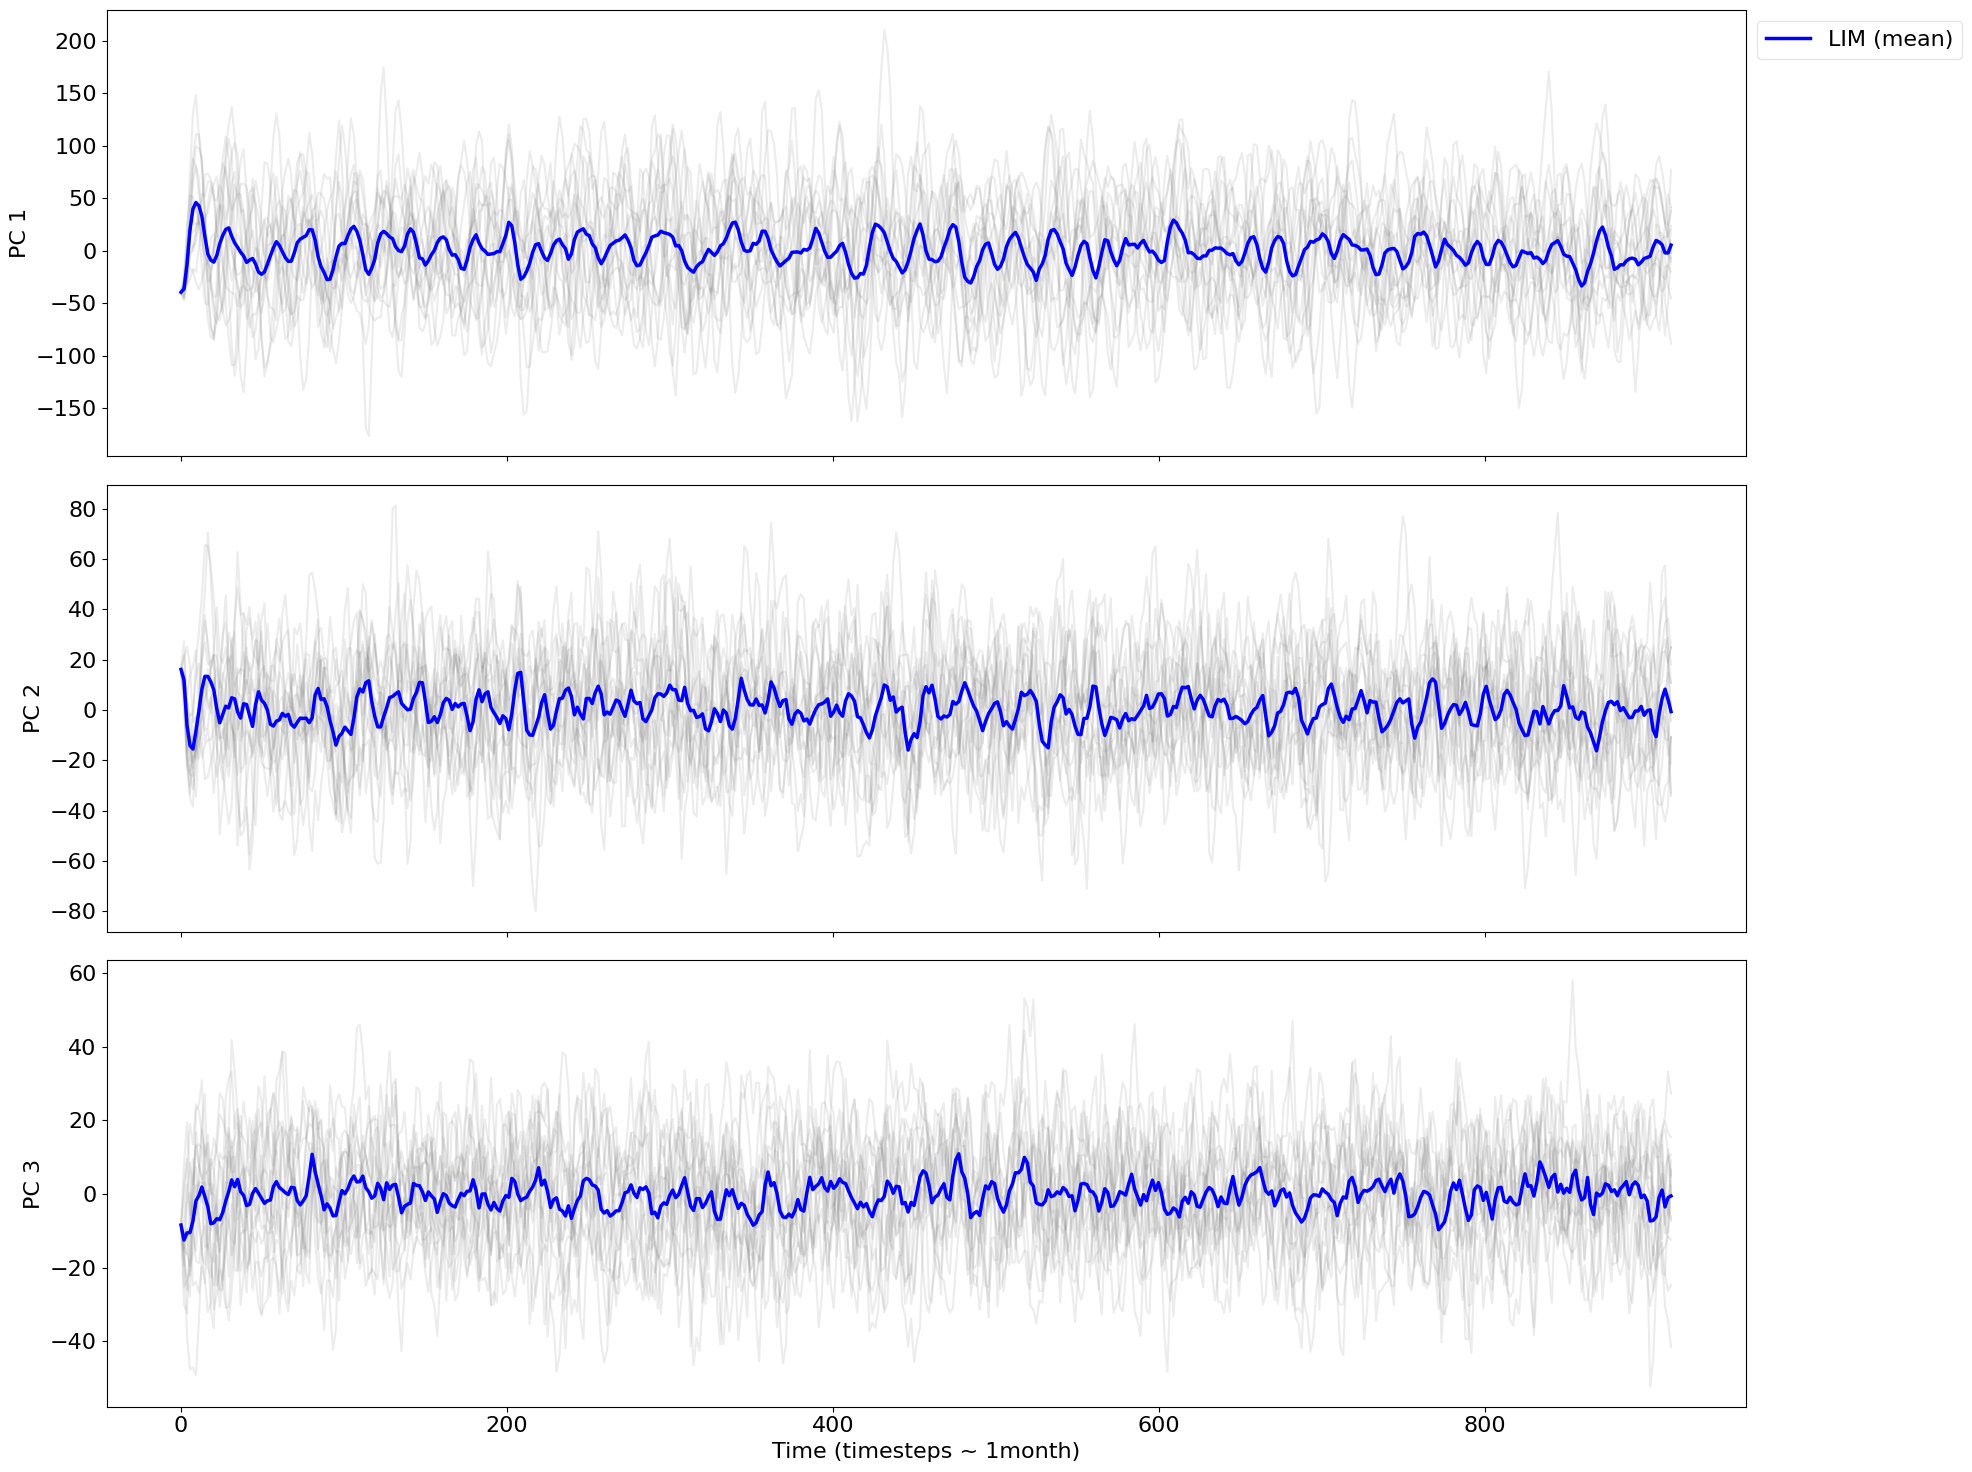

In [79]:
# Noise Integration

num_timeseries = 15

# Get input data
x_input = data_test.isel(time=0)
x_input = x_input.data

multiple_timeseries = []

for t in range(num_timeseries):
    # Forecast mean using LIM model
    lim_integration, times = model.noise_integration(x_input, timesteps=500, num_comp=len(pc_10), seed=t)
    lim_integration = lim_integration.T
    multiple_timeseries.append(lim_integration)

mean_timeseries = np.mean(multiple_timeseries, axis=0)

# Plot time evolution of selected components
idx_components = [0, 1, 2]
fig, axs = plt.subplots(len(idx_components), figsize=(20, 15), sharex=True)

for i, component in enumerate(idx_components):

    for t in range(num_timeseries):
        #print("multiple_timeseries[t][component, :]: ", multiple_timeseries[t][component, :])
        axs[i].plot(times[:], multiple_timeseries[t][component, :], color='grey', alpha=0.15)

    # Plot forecasted data using LIM model
    axs[i].plot(times[:], mean_timeseries[component, :], color="blue", label=f'LIM (mean)', linewidth=2.5)

    # Set y-axis label
    axs[i].set_ylabel(f'PC {idx_components[i]+1}')

# Add legend
_ = axs[0].legend(bbox_to_anchor=(1, 1), loc="upper left")

# Set x-axis label for the last subplot
axs[-1].set_xlabel('Time (timesteps ~ 1month)')
fig.savefig('./plots/svg/LIM_integration_timeseries_piControl.svg', format='svg')
fig.savefig('./plots/png/LIM_integration_timeseries_piControl.png', format='png')
plt.show()


In [80]:
# Create training and test data

data = pca_10.principal_components()
index_train = int(0.8 * len(data["time"]))
data_train = data[:, :index_train]

# original fit
tau = 1
model = LIM_class.LIM(tau)
model.fit(data_train.data)

logar_matr = model.logarithmic_matrix
noise_matr = model.noise_covariance


# Get input data
x_input = data_test.isel(time=0)
x_input = x_input.data

# Forecast mean using LIM model
lim_integration, times_ = model.noise_integration(x_input, timesteps=10000, num_comp=len(pc_10))
lim_integration = lim_integration.T

tau = 1
model2 = LIM_class.LIM(tau)
model2.fit(lim_integration)

logar_matr2 = model2.logarithmic_matrix
noise_matr2 = model2.noise_covariance

Covariance matrix has negative values!
0.57874274
t_delta: 1.8284970932643576
Negative eigenvalues detected.
Covariance matrix has negative values!


G_min : [-0.19221945, -0.653609597516224]
G_max : [0.97796184, 0.9997991794748375]
L_min : [-0.43890327, -2.7917359933303674]
L_max : [0.30005682, 2.225056566252923]
Q_min : [-7.2329226, -42.60454739765699]
Q_max : [37.529648, 179.72311638683163]


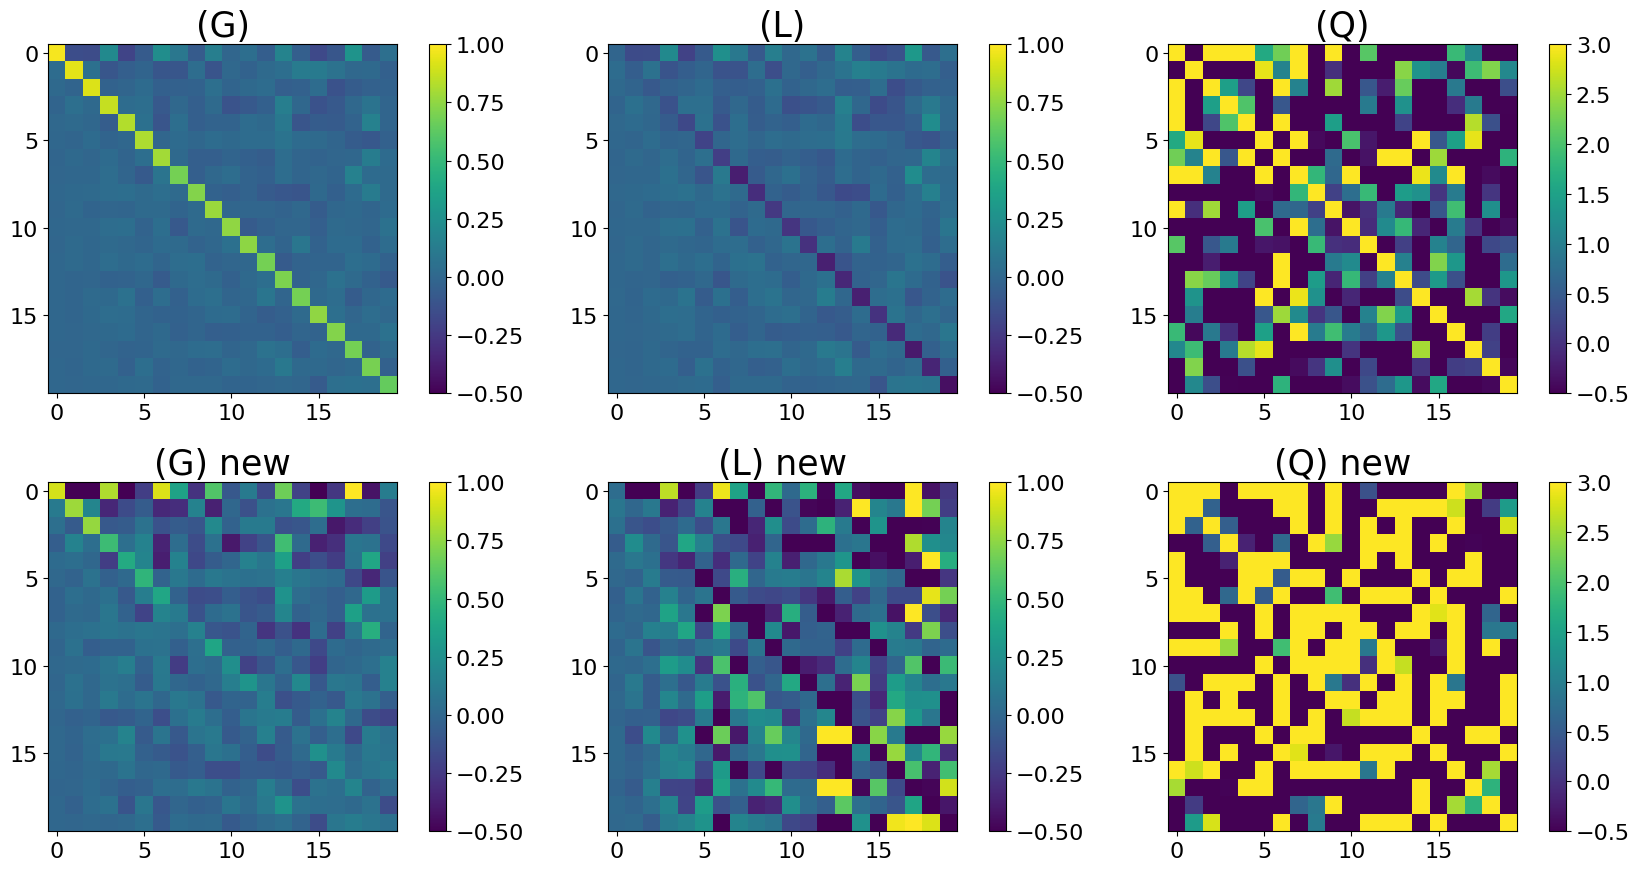

In [81]:
# Plot G, L, Q
fig, axs = plt.subplots(2, 3, figsize=(18, 9))

# Plot G
im1 = axs[0][0].imshow(model.green_function, vmin=-0.5, vmax=1)
#im1 = axs[0][0].imshow(model.green_function)
axs[0][0].set_title('(G)', fontsize=25)
fig.colorbar(im1, ax=axs[0][0])
im11 = axs[1][0].imshow(model2.green_function, vmin=-0.5, vmax=1)
#im11 = axs[1][0].imshow(model2.green_function)
axs[1][0].set_title('(G) new', fontsize=25)
fig.colorbar(im11, ax=axs[1][0])

g_min = [np.min(model.green_function), np.min(model2.green_function)]
g_max = [np.max(model.green_function), np.max(model2.green_function)]
print("G_min : {}".format(g_min))
print("G_max : {}".format(g_max))

# Plot L
im2 = axs[0][1].imshow(np.real(model.logarithmic_matrix), vmin=-0.5, vmax=1)
#im2 = axs[0][1].imshow(np.real(model.logarithmic_matrix))
axs[0][1].set_title('(L)', fontsize=25)
fig.colorbar(im2, ax=axs[0][1])
im21 = axs[1][1].imshow(np.real(model2.logarithmic_matrix), vmin=-0.5, vmax=1)
#im21 = axs[1][1].imshow(np.real(model2.logarithmic_matrix))
axs[1][1].set_title('(L) new', fontsize=25)
fig.colorbar(im21, ax=axs[1][1])

l_min = [np.min(np.real(model.logarithmic_matrix)), np.min(np.real(model2.logarithmic_matrix))]
l_max = [np.max(np.real(model.logarithmic_matrix)), np.max(np.real(model2.logarithmic_matrix))]
print("L_min : {}".format(l_min))
print("L_max : {}".format(l_max))


# Plot Q
im3 = axs[0][2].imshow(np.real(model.noise_covariance), vmin=-0.5, vmax=3)
#im3 = axs[0][2].imshow(np.real(model.noise_covariance))
axs[0][2].set_title('(Q)', fontsize=25)
fig.colorbar(im3, ax=axs[0][2])
im31 = axs[1][2].imshow(np.real(model2.noise_covariance), vmin=-0.5, vmax=3)
#im31 = axs[1][2].imshow(np.real(model2.noise_covariance))
axs[1][2].set_title('(Q) new', fontsize=25)
fig.colorbar(im31, ax=axs[1][2])

q_min = [np.min(np.real(model.noise_covariance)), np.min(np.real(model2.noise_covariance))]
q_max = [np.max(np.real(model.noise_covariance)), np.max(np.real(model2.noise_covariance))]
print("Q_min : {}".format(q_min))
print("Q_max : {}".format(q_max))

plt.tight_layout()
fig.savefig('./plots/svg/G_Q_L_function_piControl.svg', format='svg')
fig.savefig('./plots/png/G_Q_L_function_piControl.png', format='png')
plt.show()

C:\Users\felix\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\cbook\__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


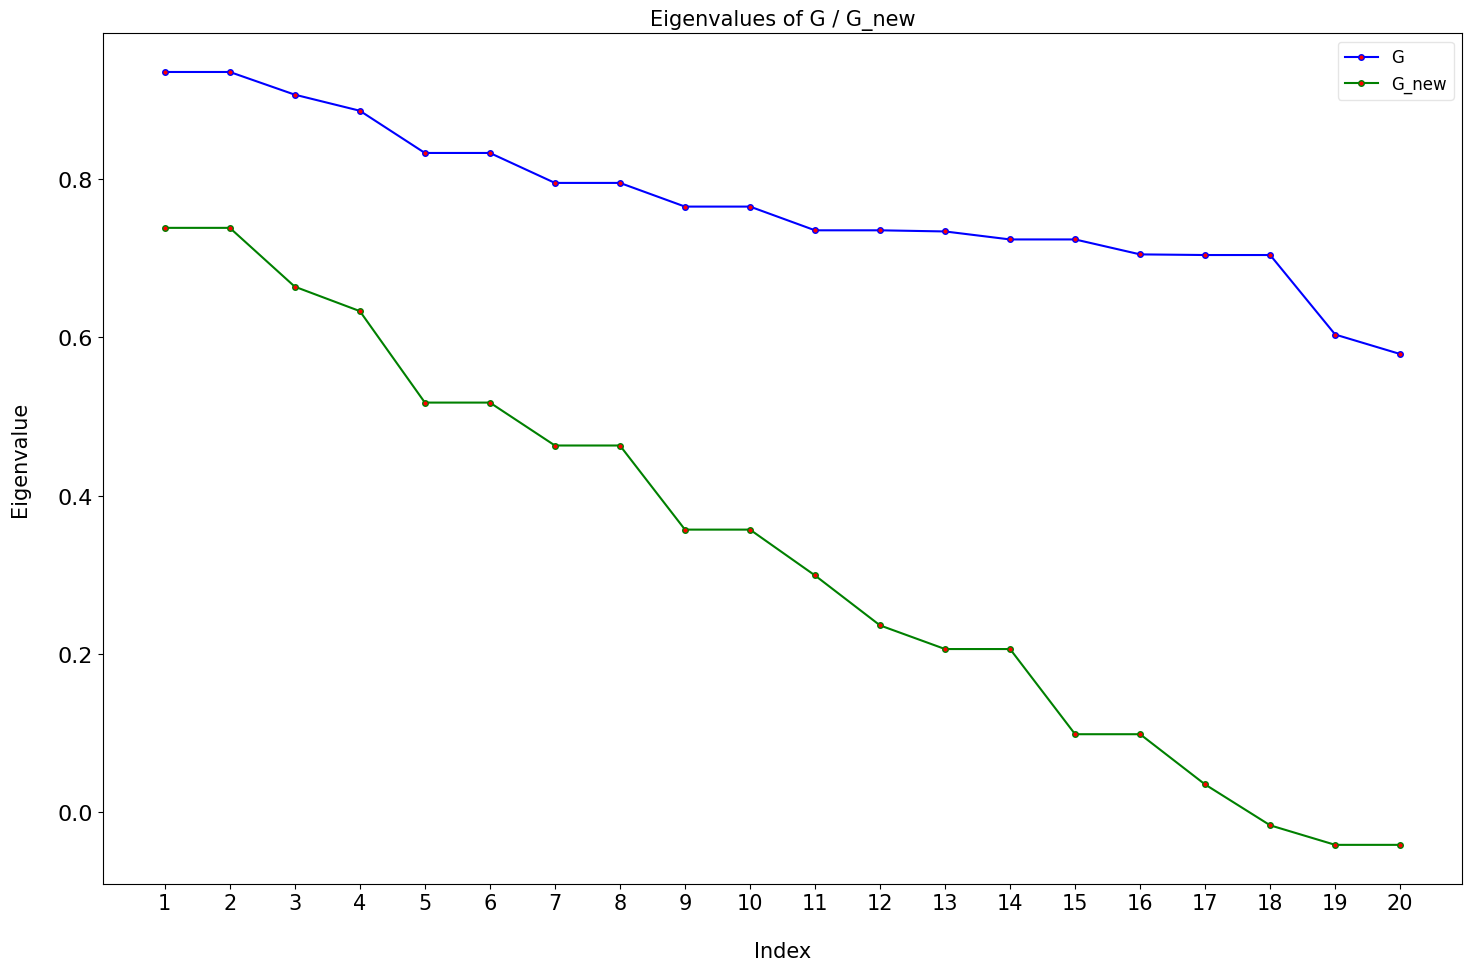

In [82]:
# Plotting eigenvalues of G
eigenvalues, _, w = ut.matrix_decomposition(model.green_function)
eigenvalues2, _, w = ut.matrix_decomposition(model2.green_function)

x = np.arange(1, len(eigenvalues) + 1)

# Plot the eigenvalues
plt.figure(figsize=(15,10))
plt.plot(x, eigenvalues, marker='o', linestyle='-', color='b', markersize=4, markerfacecolor='r', linewidth=1.5, label='G')
plt.plot(x, eigenvalues2, marker='o', linestyle='-', color='g', markersize=4, markerfacecolor='r', linewidth=1.5, label='G_new')
# Set the labels and title
plt.xlabel('Index', fontsize=15, labelpad=20)
plt.ylabel('Eigenvalue', fontsize=15, labelpad=20)
plt.title('Eigenvalues of G / G_new', fontsize=15)

# Set the x-axis tick labels
plt.xticks(x, fontsize=15)
plt.legend(loc="upper right", fontsize=12)



# Display the plot
plt.savefig('./plots/svg/eigenvalues_G_combined_piControl.svg', format='svg')
plt.savefig('./plots/png/eigenvalues_G_combined_piControl.png', format='png')
plt.show()


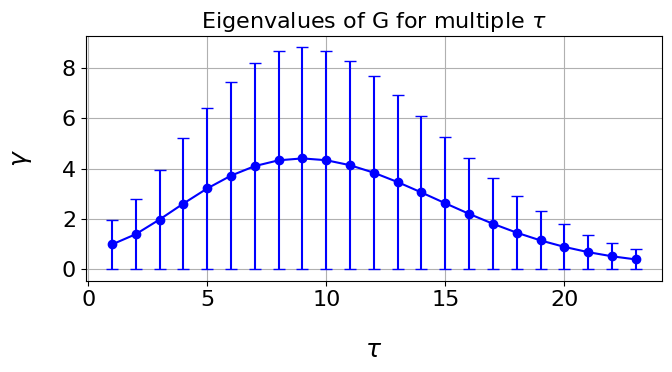

In [83]:
#Plotting G for tau [0...25]

lag_arr = np.arange(1, 24, 1)
growth_arr = []
growth_arr_min = []
growth_arr_max = []
growth_arr_minmax = []

for lag in lag_arr:
    w, U, V = ut.matrix_decomposition(model.green_function)
    G_tau = U @ np.diag(w**(lag/model.tau)) @ np.linalg.inv(U)
    w_tau, U_tau, V_tau = ut.matrix_decomposition(G_tau.T @ G_tau)
    w_tau_min = np.min(w_tau.real)
    w_tau_max = np.max(w_tau.real)
    growth_arr_min.append(w_tau_min)
    growth_arr_max.append(w_tau_max)
    growth_arr.append(w_tau[0])

growth_arr_minmax = [(growth_arr_min[i] + growth_arr_max[i])/2 for i in range(len(growth_arr_min))]

# Plot growth
fig, ax = plt.subplots()
ax.plot(lag_arr, growth_arr_minmax, marker='o', linestyle='-', color='b')
ax.errorbar(lag_arr, growth_arr_minmax, yerr=growth_arr_minmax,
             linestyle='', color='b', capsize=4)
_ = ax.set_xlabel(r"$\tau$", fontsize=18, labelpad=20)
_ = ax.set_ylabel(r"$\gamma$", fontsize=18, labelpad=20)
_ = ax.set_title(rf"Eigenvalues of G for multiple $\tau$", fontsize=16)
ax.grid('y')
plt.savefig('./plots/svg/G_eigenvalues_multiple_tau_piControl.svg', format='svg')
plt.savefig('./plots/png/G_eigenvalues_multiple_tau_piControl.png', format='png')
plt.show()


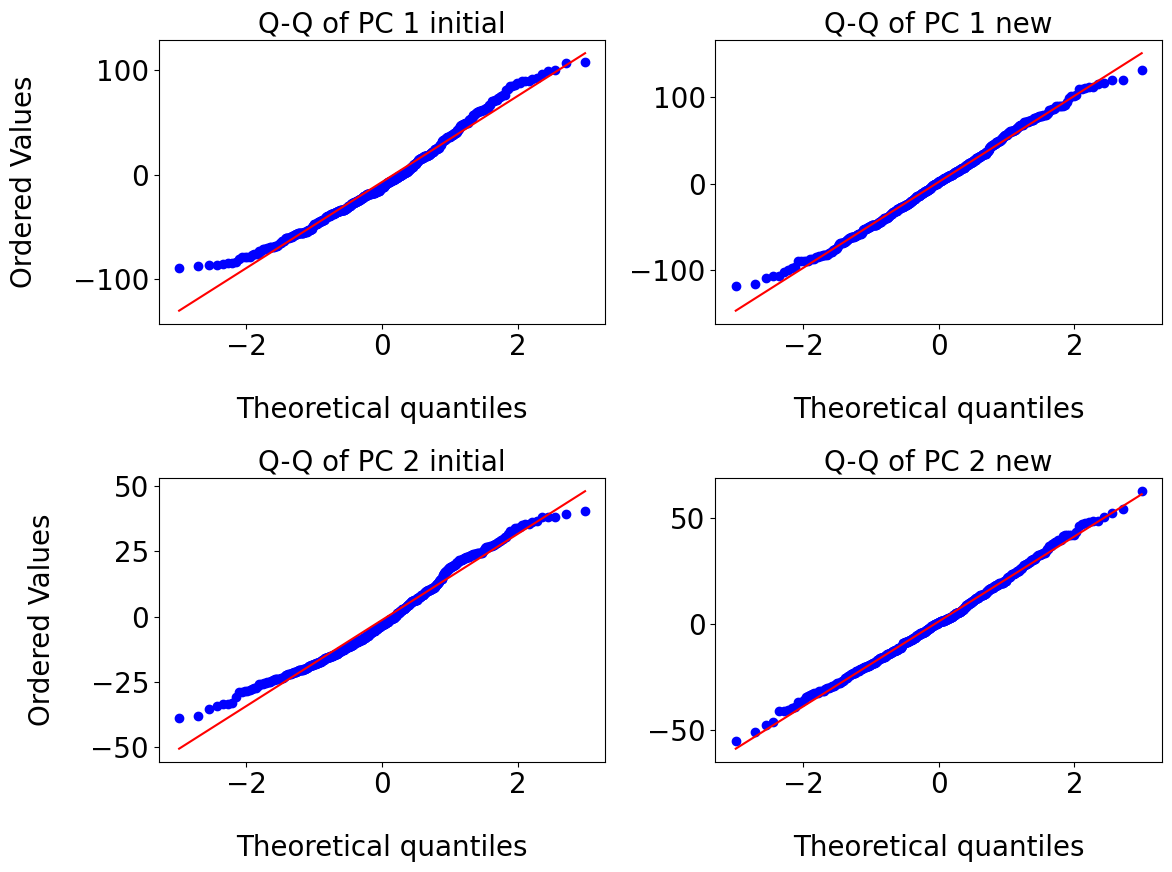

In [84]:
import scipy.stats as stats

pc_10 = np.array(pc_10)

# Set the number of plots to 2
number_of_plots = 2

# Create the figure and axes objects
fig, axs = plt.subplots(number_of_plots, 2, figsize=(12, 9))

# Set titles and plot the contourf and plot for each EOF and PC
for i in range(number_of_plots):
    stats.probplot(pc_10[i, :500], dist="norm", plot=axs[i,0])
    axs[i,0].set_title("Q-Q of PC {} initial".format(i + 1), fontsize=20)
    axs[i,0].set_xlabel("Theoretical quantiles", fontsize=20, labelpad=25)
    axs[i,0].set_ylabel("Ordered Values", fontsize=20, labelpad=25)
    axs[i,0].tick_params(axis='both', which='major', labelsize=20)

    stats.probplot(lim_integration[i, :500], dist="norm", plot=axs[i, 1])
    axs[i,1].set_title("Q-Q of PC {} new".format(i + 1), fontsize=20)
    axs[i,1].set_xlabel("Theoretical quantiles", fontsize=20, labelpad=25)
    axs[i,1].set_ylabel("", fontsize=20, labelpad=25)
    axs[i,1].tick_params(axis='both', which='major', labelsize=20)

# Add padding between subplots and adjust layout
fig.tight_layout(pad=2)
plt.savefig('./plots/svg/QQ_plot_PC_seperat_piControl.svg', format='svg')
plt.savefig('./plots/png/QQ_plot_PC_seperat_piControl.png', format='png')
plt.show()



In [85]:
#pc_10 = np.array(pc_10)

#theoretical_quantiles = np.linspace(0, 1, len(pc_10[0, :500]))

# Set the number of plots to 2
#number_of_plots = 10

# Create the figure and axes objects
#fig, axs = plt.subplots(number_of_plots, 1, figsize=(25, 80))

# Set titles and plot the contourf and plot for each EOF and PC
#for i in range(number_of_plots):
#    axs[i].plot(stats.norm.ppf(theoretical_quantiles), pc_10[i, :500], 'bo', label='PC {} initial'.format(i + 1))
#    axs[i].plot(stats.norm.ppf(theoretical_quantiles), lim_integration[i, :500], 'ro', label='PC {} new'.format(i + 1))
#    axs[i].set_title("Q-Q of PC {}".format(i + 1), fontsize=30)
#    axs[i].set_xlabel("Theoretical quantiles", fontsize=30)
#    axs[i].set_ylabel("Ordered Values", fontsize=30)
#    axs[i].tick_params(axis='both', which='major', labelsize=30)
#    axs[i].legend(loc='upper right', fontsize=30)

# Add padding between subplots and adjust layout
#fig.tight_layout(pad=2)
#plt.savefig('./plots/svg/QQ_plot_PC_combined_piControl.svg', format='svg')
#plt.savefig('./plots/png/QQ_plot_PC_combined_piControl.png', format='png')
#plt.show()


Generated timesteps : [-39, -31, -22, -13, -4, 5, 14, 23, 32, 41]
Timestep counts : [8, 37, 92, 105, 87, 74, 45, 37, 15, 0]


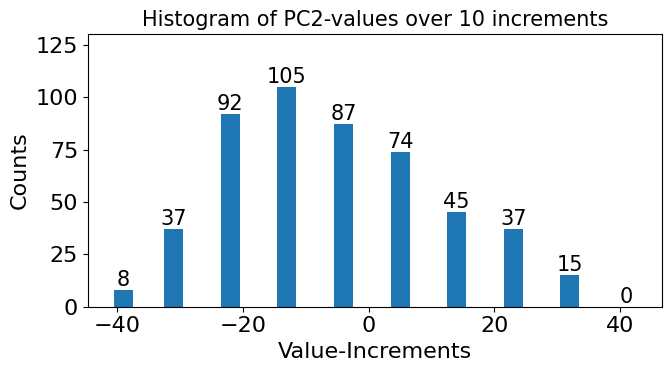

In [86]:
def generate_timesteps(values, num_timesteps):
    min_value = round(min(values))
    max_value = round(max(values))
    timestep_values = np.linspace(min_value, max_value, num_timesteps, dtype = int)
    return timestep_values.tolist()

def count_values_by_timestep(timesteps, values):
    timestep_counts = []

    # Sort the timesteps in ascending order
    sorted_timesteps = sorted(timesteps)

    # Iterate over each timestep (except the last one)
    for i in range(len(sorted_timesteps)-1):
        count = 0
        # Check if each value falls within the current timestep range
        for value in values:
            if sorted_timesteps[i] <= value < sorted_timesteps[i+1]:
                count += 1
        timestep_counts.append(count)

    # Count the values that fall within the last timestep range
    last_timestep_count = 0
    for value in values:
        if value >= sorted_timesteps[-1]:
            last_timestep_count += 1
    timestep_counts.append(last_timestep_count)
    return timestep_counts



timesteps = generate_timesteps(pc_10[1, :500], 10)
print("Generated timesteps : {}".format(timesteps))

counts = count_values_by_timestep(timesteps, pc_10[1, :500])
print("Timestep counts : {}".format(counts))


plt.bar(timesteps, counts, align='center', width=3)

for i, count in enumerate(counts):
    plt.text(timesteps[i], count, str(count), ha='center', va='bottom', fontsize=15)

plt.ylim(0, (max(counts) + 25))
plt.xlabel('Value-Increments')
plt.ylabel('Counts')
plt.title('Histogram of PC2-values over 10 increments', fontsize=15)

plt.savefig('./plots/svg/pc_data_distribution_piControl.svg', format='svg')
plt.savefig('./plots/png/pc_data_distribution_piControl.png', format='png')
plt.show()